In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Dataset: Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [29]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis=1)


df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


Plotting

In [30]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


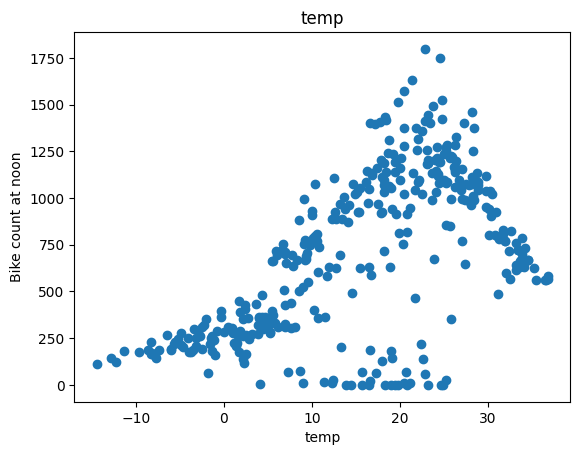

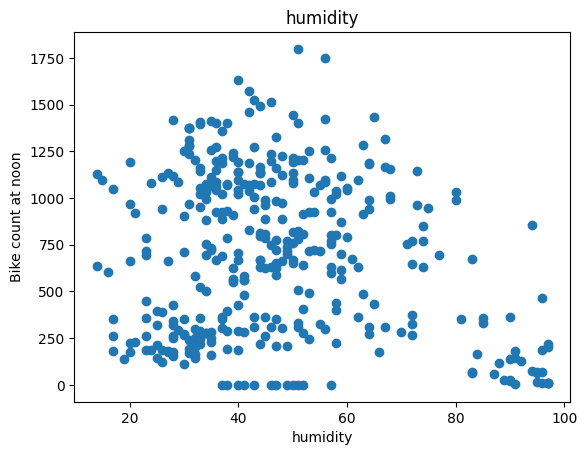

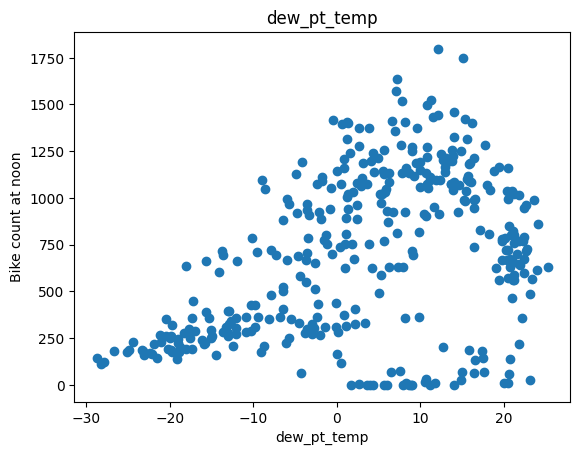

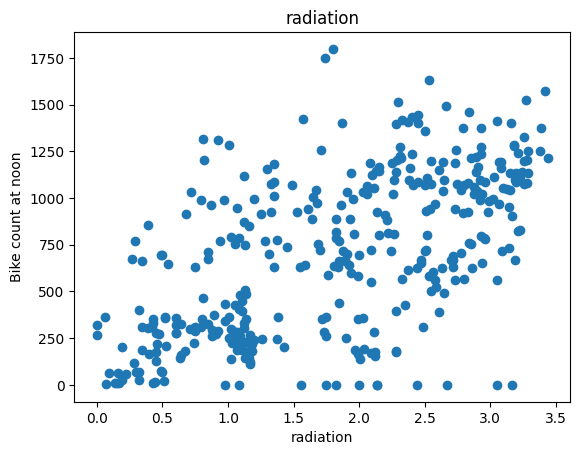

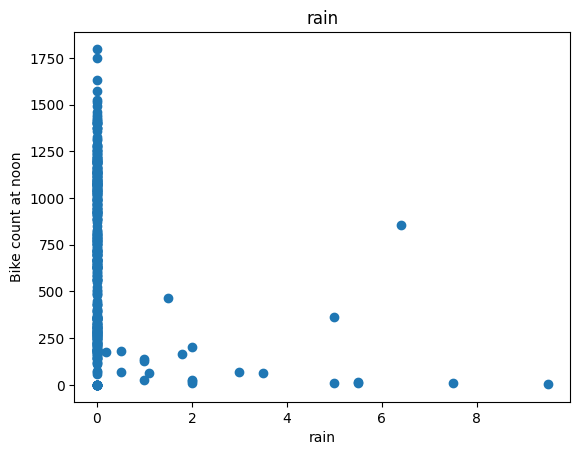

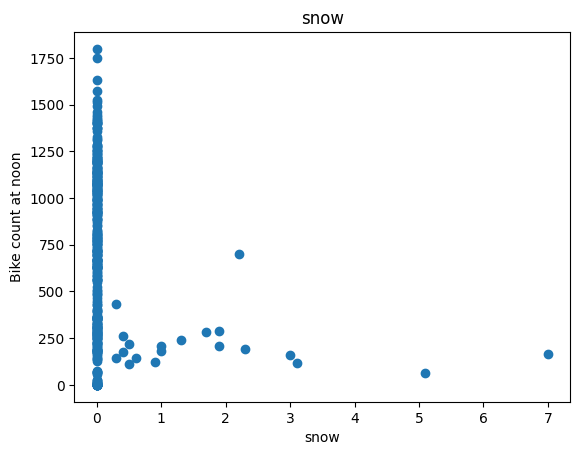

In [31]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike count at noon')
    plt.xlabel(label)
    plt.show()

Train, valid and test dataset

In [32]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

d:\Playground\machine-learning-for-everybody\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [33]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values
    
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))
    
    return data, X, y

In [34]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [35]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [36]:
print(temp_reg.coef_, temp_reg.intercept_)

print(temp_reg.score(X_test_temp, y_test_temp))

[[22.36079056]] [365.64402701]
0.15810638036546965


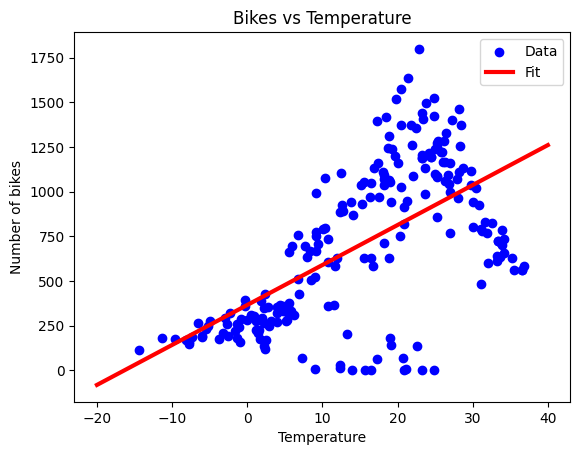

In [37]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temperature')
plt.ylabel('Number of bikes')
plt.xlabel('Temperature')
plt.show()

### Multiple Linear Regression

In [38]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

d:\Playground\machine-learning-for-everybody\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [39]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [40]:
all_reg.score(X_test_all, y_test_all)

0.46871734225637496

### Regression with Neural Net

In [41]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [42]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(1)
])

In [43]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [44]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

In [45]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

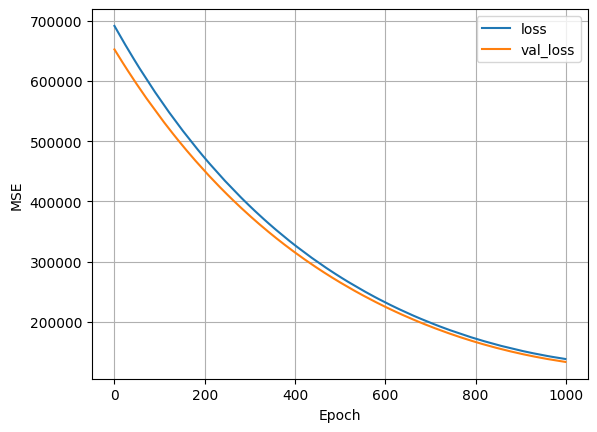

In [46]:
plot_loss(history)

4/4 [==============================] - 0s 5ms/step


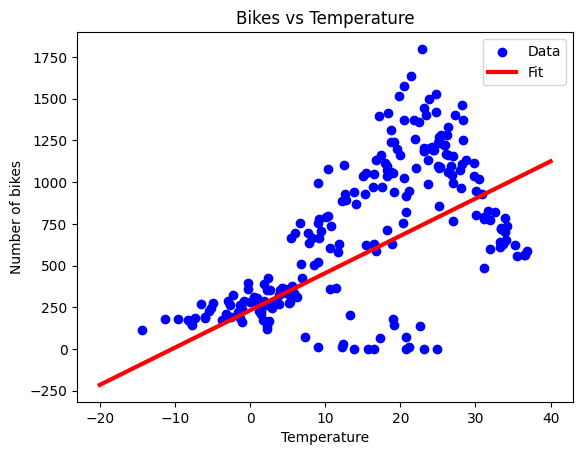

In [47]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temperature')
plt.ylabel('Number of bikes')
plt.xlabel('Temperature')
plt.show()

### Neural Network

In [48]:
nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])


nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [49]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0,
    epochs=100
)

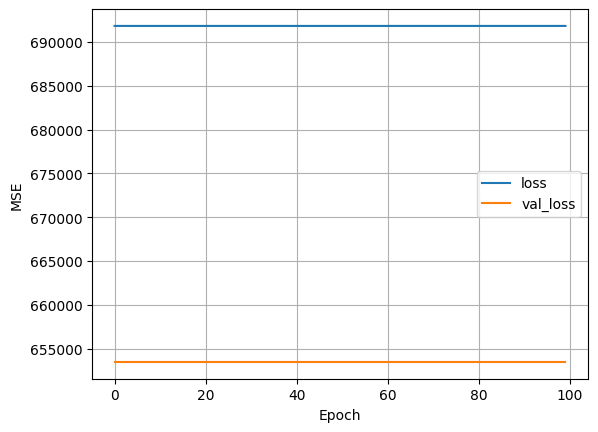

In [50]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


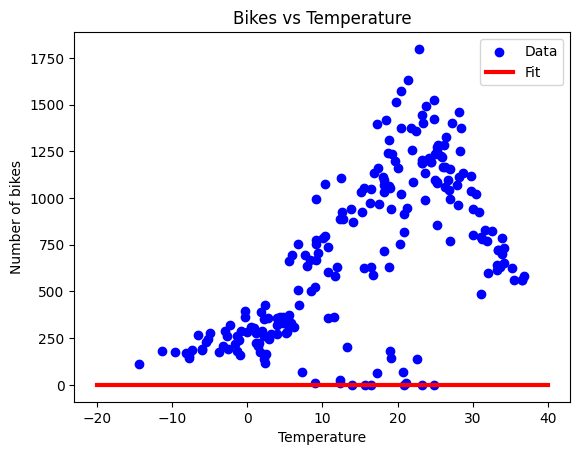

In [51]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temperature')
plt.ylabel('Number of bikes')
plt.xlabel('Temperature')
plt.show()

#### Neural net for all dataset

In [69]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [70]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [71]:
history = nn_model.fit(
    X_train_all, y_train_all, 
    validation_data=(X_val_all, y_val_all),
    verbose=0,
    epochs=100
)

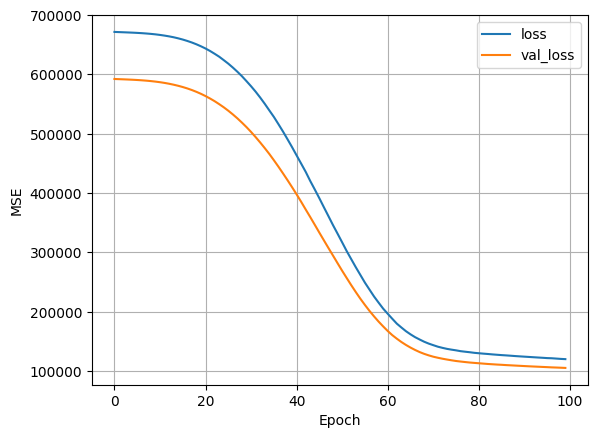

In [72]:
plot_loss(history)

In [73]:
# Calculate MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 3ms/step


In [74]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [75]:
print(MSE(y_pred_lr, y_test_all))
print(MSE(y_pred_nn, y_test_all))

97427.48711838116
129495.80882089488


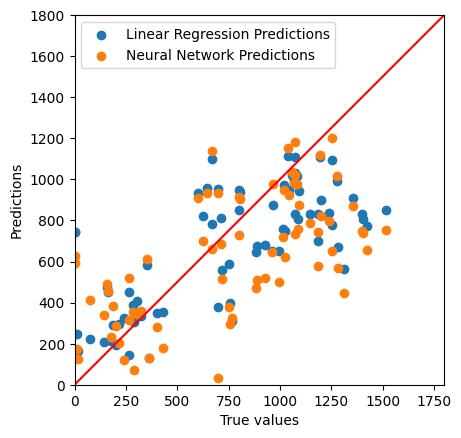

In [81]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='Linear Regression Predictions')
plt.scatter(y_test_all, y_pred_nn, label='Neural Network Predictions')
plt.xlabel("True values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')